### For this exercise you need additional libraries

use `pip install` to add the following packages to your system
- seaborn
- sklearn == 0.22.1
- pandas

In [16]:
%matplotlib notebook
import numpy as np
import seaborn as sn

import pandas as pd
from collections import Counter 
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from skimage.feature import hog
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import display, clear_output
from PIL import Image, ImageOps
from glob import glob
import warnings
from random import shuffle
warnings.filterwarnings('ignore')

sn.set_theme()

In [17]:
# read a list of images from hdd
files = glob('resources/images/**/*.jpg')
shuffle(files)

# convert all images to an rgb image
images = [Image.open(x).convert('RGB') for x in files]

# extract the class of each image based on the folder where the image is located
labels = [f.split(os.path.sep)[-2] for f in files]

# instanciate a label encoder to convert text labels into numerical labels
le = LabelEncoder()
y_true = le.fit_transform(labels)

## Classification using KNN

For this task you have to implement the KNN classification based on features using the Euclidean distance. What kind of features you use is up to you but a good starting point is the implementation of the [Histogram of Ordientated Gradients](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=hog#skimage.feature.hog). You can also combine multiple features which you use for your final classification. A list of additional features can be found [here](https://scikit-image.org/docs/dev/api/skimage.feature.html).

For example, you use the HOG implementation of scikit-image with 9 orientations and 32 pixels per cell in an image with 128 x 128px, you receive a feature vector with the length of 324. Another feature will be based on the mean color in a consistent grid. You seperate your source image in a 4 x 4 grid and calculate the mean color of each cell, this results in a feature vector with the dimension 4 x 4 x 3 which you need to flatten to the length of 48. For your final feature vector you just need concatenate both vectors to a final feature vector of size 372. 


### Confusion Matrix
Based on the results for your KNN classification you have to create the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Once this is done, you have to calculate the **Accuracy**, **Precision** and **Recall** by using the confusion matrix. 

![](resources/confusion_matrix.png)

**Hints**

- For HOG you have to use the same image size for all calculations otherwise you get different feature vectors whith different length
- If you use color as feature, try to normalize these values
- np.concatenate allows you to merge your feature to the final feature vector
- np.argsort return the indices of a sorted array 
- you can calculate the precision, recall a.s.o from the confusion matrix like below

<table align="left"><tr><td>
<img src="resources/hint_cm.png" align="left" width=300 />
    </td></tr>
    <tr><td>
    <small>Source: https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal</small>
        </td></tr></table>
        

In [18]:
similarity_plot = None
def run_similarity(features, event=None):
    """ 
    Creates an image grid for the similarity search example
    """
    
    clear_output()
    idx = 0
    
    if event is not None and hasattr(event.inaxes, 'name'):
        idx = int(event.inaxes.name)
    
    query_feature = features[idx]
    k = len(features)
    indices = knn(query_feature, features, k)
    
    return plot_image_grid(images[idx], indices, features)

def plot_image_grid(query, indices, features): 
    global similarity_plot
    
    if similarity_plot is None:
        similarity_plot = plt.subplots(1,2, figsize=(10,6))
        similarity_plot[0].canvas.mpl_connect('button_press_event', lambda x: run_similarity(features, x))
        
    similarity_plot[0].patch.set_visible(False)
    
    similarity_plot[1][0].set_title("Query")
    similarity_plot[1][0].axis('off')
    similarity_plot[1][0].imshow(query)
    similarity_plot[1][0].grid(False)
    
    grid = ImageGrid(similarity_plot[0], 122, nrows_ncols=(10,10), axes_pad=0)
    similarity_plot[1][1].set_title("Results")
    similarity_plot[1][1].axis('off')
    
    for ax, idx in zip(grid, indices):
        ax.axis('off')
        ax.name = idx
        ax.imshow(ImageOps.fit(images[idx], (64,64), Image.ANTIALIAS))
        
    plt.tight_layout()    
    
def plot_confusion_matrix(cm, label_names, ax): 
    """ 
    Function to plot a confusion matrix
    
    Args:
        cm (np.ndarray): Confusion matrix to visualize
        label_names (list of strings): label names used as x and y axis label
    """    
    df_cm = pd.DataFrame(cm, label_names, label_names)
    sn.set(font_scale=1) # for label size    
    sn.heatmap(df_cm, annot=True, cmap='Blues', cbar=False, ax=ax) # font size
    
    accuracy, precision, recall = get_metrics(cm)
    stats = f"\nAccuracy {accuracy:.3f}\nPrecision {precision:.3f}\nRecall {recall:.3f}\n"
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label \n' + stats)    

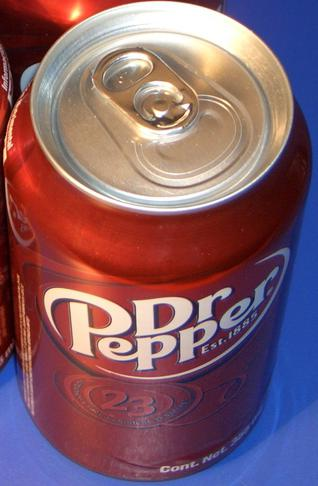

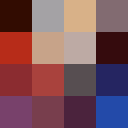

(None, None)

In [19]:
display(images[10]), display(images[10].resize((4,4), Image.NEAREST).resize((128,128), Image.NEAREST))

### Solution

In [20]:
distances = np.array([10,5,0,20,3])
args = np.argsort(distances)

args, distances[args]

(array([2, 4, 1, 0, 3], dtype=int64), array([ 0,  3,  5, 10, 20]))

In [30]:
def calculate_color_feature(sample):
    return np.array(sample.resize((4,4), Image.NEAREST)).flatten() / 255.0

def calculate_hog(sample):
    sample = sample.resize((128,128))
    return hog(sample, pixels_per_cell=(16, 16))

def get_metrics(cm):
    """
    Calculates the Accuracy, Precision and Recall based on a confusion matrix
    
    Args:
        cm (np.ndarray): Confusion Matrix        
        
    Returns:
        tuple(float, float, float): Returns a tuple containing the accuracy, precission and recall for a confusion matrix    
    """
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    accuracy = np.diag(cm) / np.sum(cm)
        
    return accuracy.sum(), precision.mean(), recall.mean()

def get_features(sample):
    """
    Calculates a feature vector for an image
    
    Args:
        sample (Pil.Image): Image for which a feature vector is to be calculated 
        
    Returns:
        np.ndarray: calculated feature vecotr witn (N,) dimension
    """
    color = calculate_color_feature(sample)
    hog = calculate_hog(sample)
    
    return np.concatenate([hog, color])

def knn(query, features, k):    
    """
    Applies a K-Nearest-Neighboor search for a query feature
    
    Args:
        query (np.ndarray): Feature vector for searching the K nearest neighbour
        features (List of np.ndarray): Set of feature vectors to find the nearest neighbour of an query feature vector
        k (int): number of nearest nighbour
        
    Returns:
        np.ndarray: List of indices of k nearest neighboor
    """    
    dist = []
    for feature in features:
        dist += [np.sqrt(np.square(query - feature).sum())]
        
    return np.argsort(dist)[:k]  


def classification(features, k):
    """
    Applies a K-Nearest-Neighboor classification
    
    Args: 
        features (List of np.ndarray): Set of features to find the nearest neighbour of an query feature
        k (int): number of nearest nighbour
        
    Returns:
        np.ndarray: List of predicted labels
    """
    y_pred = np.zeros_like(y_true)
    for idx, (label, feature) in enumerate(zip(y_true,features)):
        indices = knn(feature, features, k+1)
        indices = [y_true[x] for x in indices][1:]        
        indices, counts = np.unique(k,return_counts=True)
        y_pred[idx] = indices[np.argmax(counts)]
    
    return y_pred  

In [22]:
m = np.array([[3,1,2,1],
              [1,6,2,3],
              [2,2,4,2],
              [7,1,2,5]])

print(np.diag(m))
print(np.sum(m, axis=1))
print(np.sum(m, axis=0))

a, p, r = get_metrics(m)
print(f"Accuracy: {a:.3f}\nPrecision: {p:.3f}\nRecall: {r:.3f}")

[3 6 4 5]
[ 7 12 10 15]
[13 10 10 11]
Accuracy: 0.409
Precision: 0.421
Recall: 0.415


In [28]:
indices = knn(images[5], features, 3+1)[1:]
print(indices)
d = [y_true[x] for x in indices]
print(d)
indices, counts = np.unique(d,return_counts=True)
print(indices, counts, np.argmax(counts))
indices[np.argmax(counts)], indices, counts, d

NameError: name 'features' is not defined

### Visualization

In [31]:
features = [get_features(image) for image in images]

y_pred = classification(features, 5)
cm = confusion_matrix(y_true, y_pred)

In [32]:
# just a check to compare the calculated results with the well implemented sklearn versions
acc, precision, recall = get_metrics(cm)
assert precision_score(y_true, y_pred, average=None).mean() == precision
assert recall_score(y_true, y_pred, average=None).mean() == recall
assert accuracy_score(y_true, y_pred).mean() == acc

AssertionError: 

<IPython.core.display.Javascript object>


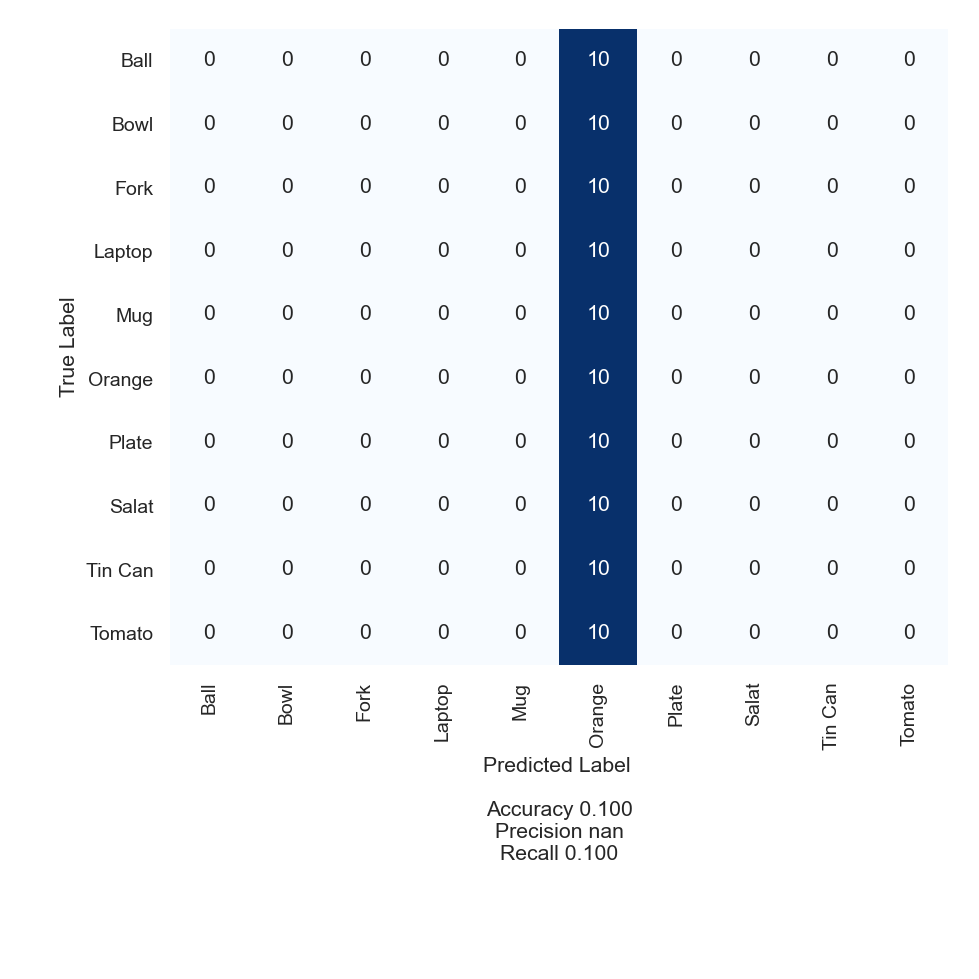

In [33]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax = plot_confusion_matrix(cm, le.inverse_transform(np.unique(y_true)), ax)
plt.tight_layout()

### Similarity

Your KNN implementation and the selected features can be used for a reverse image search. You only need to execute the run_similarity(). With a click on the image grid (right subplot) you can select your query image.

![](resources/similarity.png)

<IPython.core.display.Javascript object>


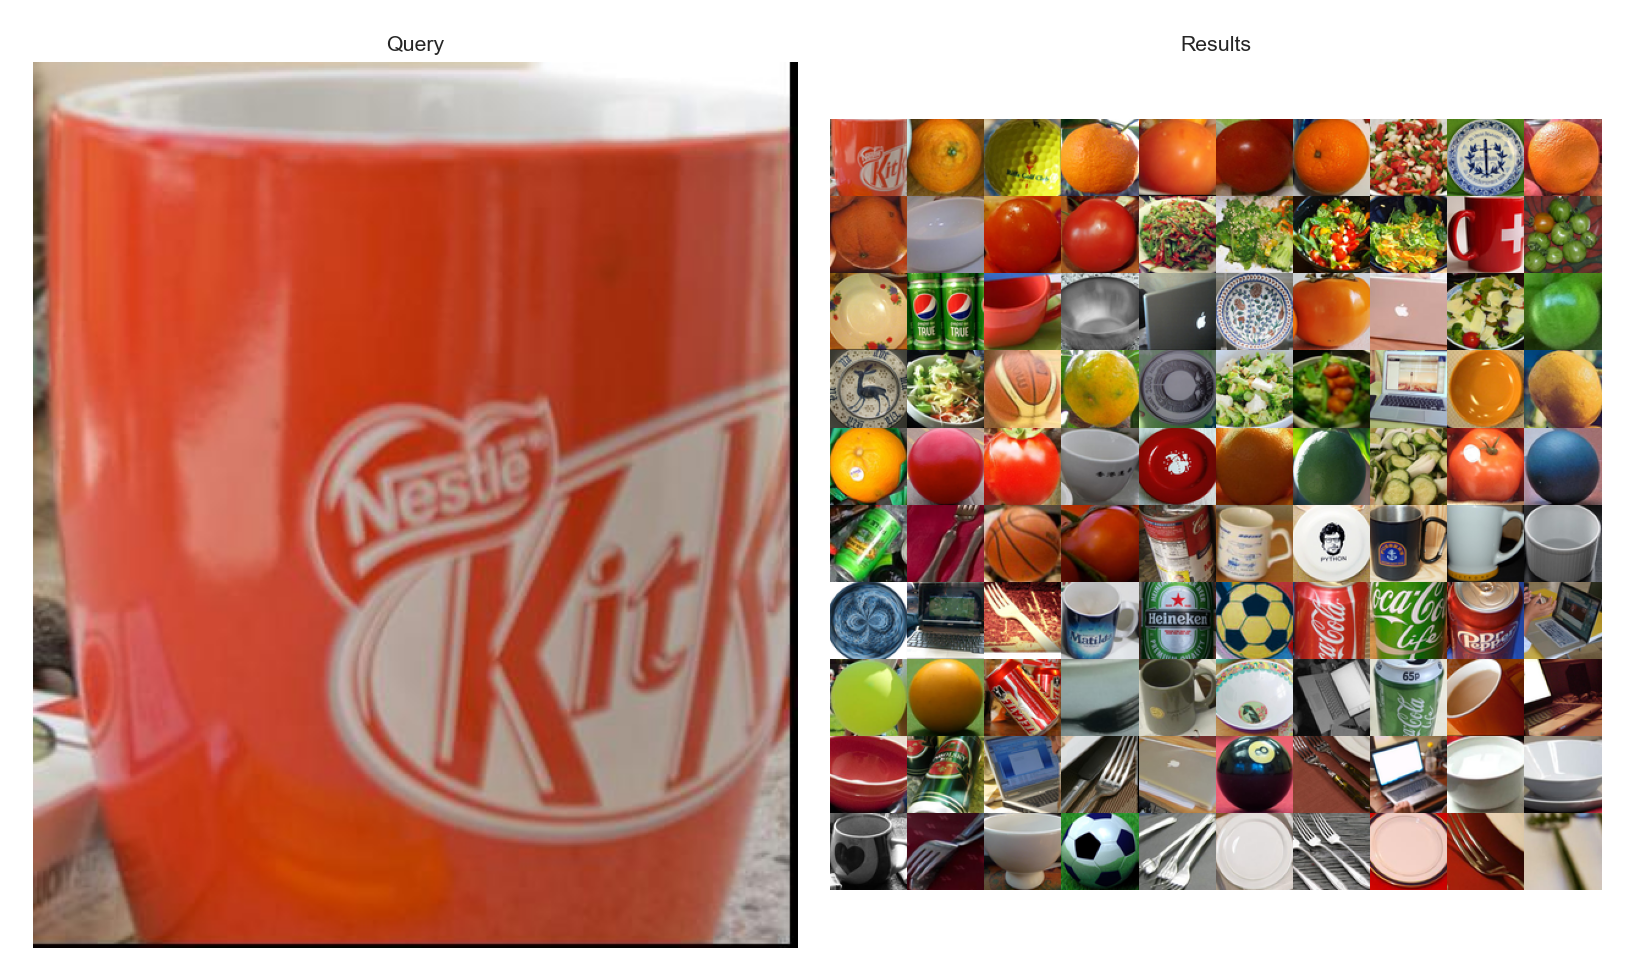

In [34]:
run_similarity(features)

In [35]:
test = np.array(images[10].resize((128,128)))
feature, hog_img = hog(test, pixels_per_cell=(32, 32), visualize=True)

In [36]:
color_feature = np.array(images[10].resize((4,4), Image.NEAREST)).flatten() / 255.0

np.concatenate([color_feature, feature]).shape

(372,)

In [37]:
feature.min(), feature.max(), color_feature.min(), color_feature.max()

(0.0034931133720363327,
 0.23688759161317338,
 0.00392156862745098,
 0.8470588235294118)

<IPython.core.display.Javascript object>


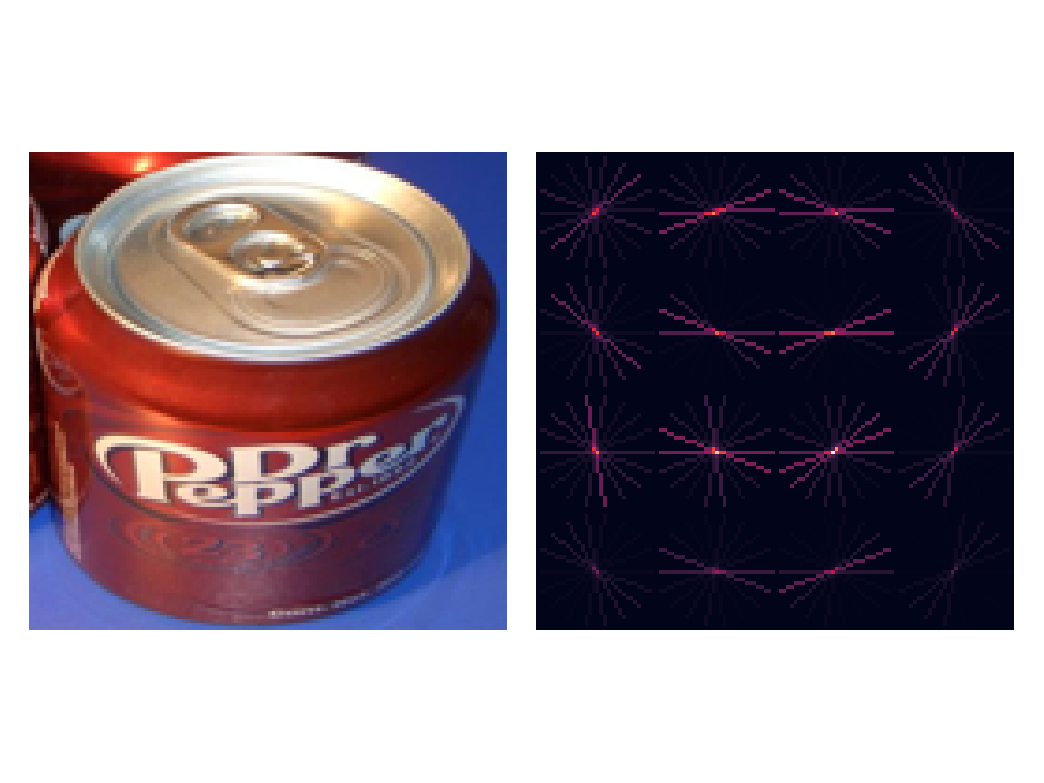

In [38]:
plt.figure()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(test)
plt.subplot(1,2,2)
plt.imshow(hog_img)
plt.axis('off')
plt.tight_layout()

In [39]:
cm = (np.random.rand(3,3) * 10).astype(np.uint)
cm, get_metrics(cm)

(array([[2, 4, 9],
        [9, 5, 5],
        [0, 6, 2]], dtype=uint32),
 (0.21428571428571427, 0.21338383838383837, 0.21549707602339183))